In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklift.models import SoloModel, TwoModels
from sklift.metrics.metrics import qini_auc_score

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


from catboost import CatBoostClassifier, CatBoostRegressor

# Прочитаем файл с данными
df = pd.read_csv("data/criteo-uplift-v2.1.csv")
df.head()

Failed to import duecredit due to No module named 'duecredit'


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [2]:
df['treatment'].value_counts()

treatment
1    11882655
0     2096937
Name: count, dtype: int64

Группы не сбалансированы

In [3]:
# Закодируем категориальные признаки
df = pd.get_dummies(df)

# Выведем размерности:
print(df.shape)

(13979592, 16)


In [4]:
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [5]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
                'f11', 'visit', 'exposure']

target_col = 'conversion'
treatment_col = 'treatment'

In [6]:
df_train, df_test = train_test_split(
    df, 
    stratify=df[[treatment_col, target_col]], 
    random_state=7, 
    test_size=0.3
)
print(df_train.shape)
print(df_test.shape)

df_train.head()

(9785714, 16)
(4193878, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
2913094,21.994387,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
6265,24.362690,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
10973910,24.053317,10.059654,8.214383,4.679882,10.280525,4.115453,-12.269776,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
12410136,21.407143,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
10106477,23.290999,10.059654,8.214383,4.679882,10.280525,4.115453,-3.282109,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [7]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['treatment'] == 0)
    N_t = sum(ranked['treatment'] == 1)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[(ranked.treatment == 0)&(ranked.conversion == 1),'n_c1'] = 1
    ranked.loc[(ranked.treatment == 1)&(ranked.conversion == 1),'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print(qini_auc_score(y_true=ranked.conversion, uplift=ranked.uplift, treatment=ranked.treatment))
    print('Qini score: {:.3f}'.format(quni_score))

### S-learner

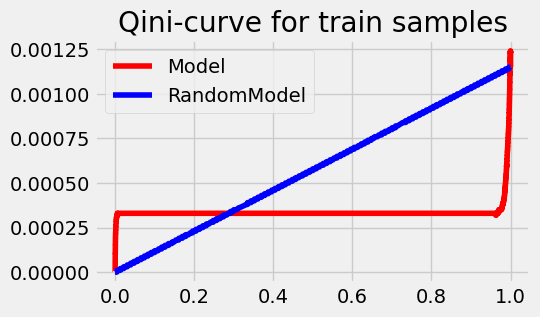

-0.04113669035699633
Qini score: -2334.308


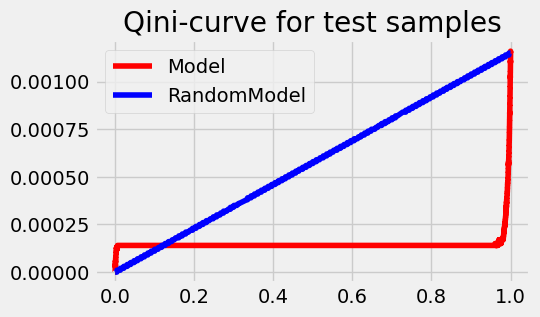

0.06533896344365894
Qini score: -1798.483


In [9]:
# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=7, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

### T-learner

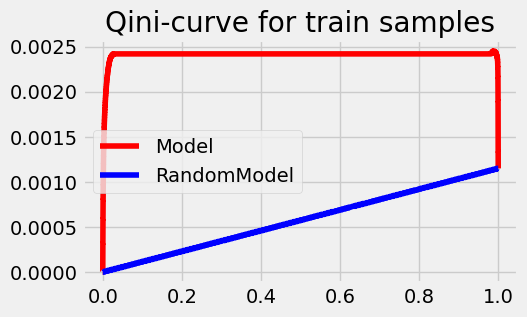

-0.22592020510451616
Qini score: 17957.488


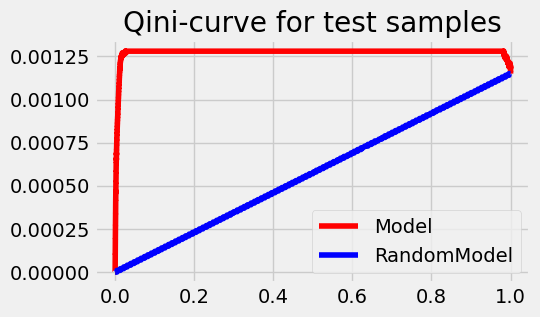

-0.2257935008935543
Qini score: 2927.756


In [10]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=7, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

### Uplift-tree

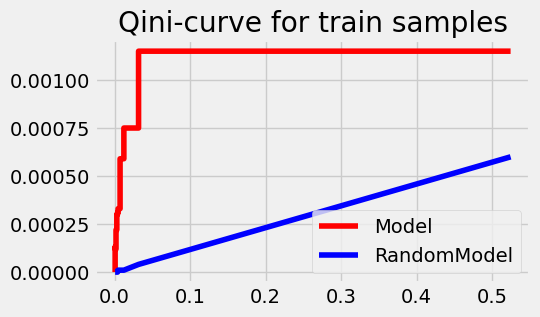

-0.2210595071600564
Qini score: 5482.509


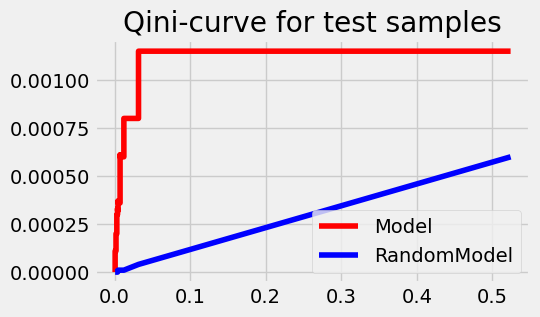

-0.22183943516912008
Qini score: 2356.401


In [31]:
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=7
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_train[feature_cols].values.copy()))[:, 1]
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_test[feature_cols].values.copy()))[:, 1]
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

### Вывод

Лучший результат у T-learner. Дальнейшие расчеты продолжатся на сильноурезанных данных, потому что X- и R-learner очень долго работают(за ночь даже один не посчитал).

## На сокращённых данных

In [22]:
_, df1 = train_test_split(
    df, 
    stratify=df[[treatment_col, target_col]], 
    random_state=7, 
    test_size=0.01
)
print(df1.shape)

(139796, 16)


In [23]:
df_train1, df_test1 = train_test_split(
    df1, 
    stratify=df1[[treatment_col, target_col]], 
    random_state=7, 
    test_size=0.3
)
print(df_train1.shape)
print(df_test1.shape)

df_train1.head()

(97857, 16)
(41939, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
121690,12.616365,10.059654,9.029140,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
9574238,17.309652,10.059654,8.599906,0.028363,10.280525,4.115453,-9.238756,4.833815,3.920995,22.570329,5.300375,-0.168679,1,0,0,0
170958,12.616365,10.059654,9.025090,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
8683510,14.056176,10.059654,8.431825,1.433141,11.029584,4.115453,-12.347072,4.833815,3.802376,43.657577,5.605103,-0.267350,1,0,1,1
12988951,25.352769,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0


### S-learner

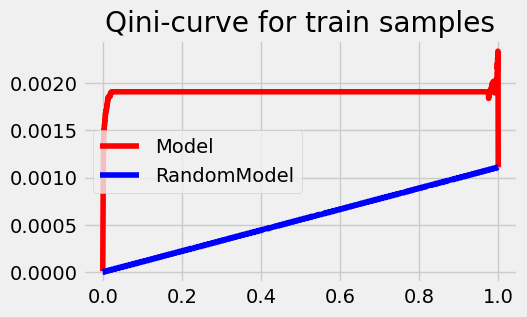

-0.22555062966049916
Qini score: 132.236


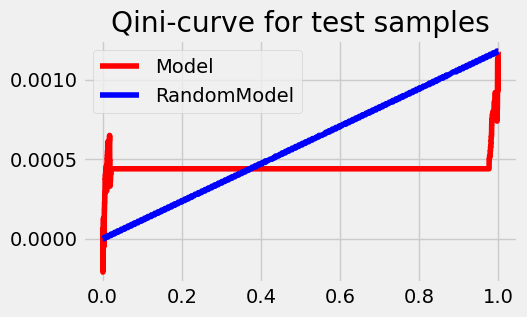

0.0660858173271926
Qini score: -6.058


In [24]:
# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=7, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=df_train1[feature_cols],
              treatment=df_train1[treatment_col],
              y=df_train1[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(df_train1[feature_cols].values.copy()))
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(df_test1[feature_cols].values.copy()))
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

### T-learner

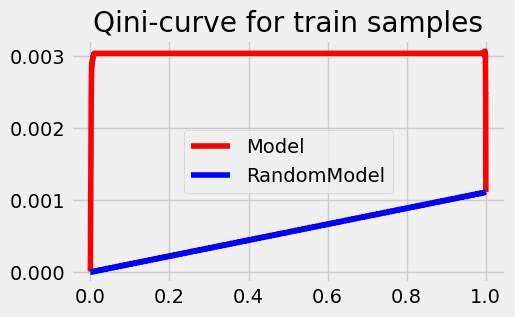

-0.20820541367193462
Qini score: 242.646


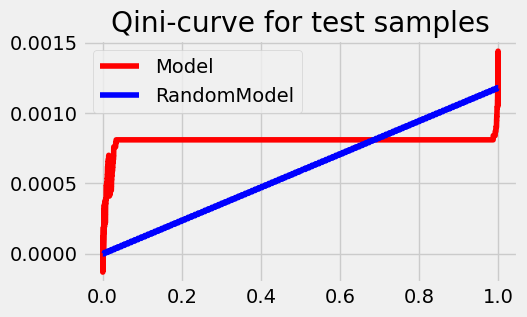

-0.08930657160280493
Qini score: 8.867


In [25]:
# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=7, verbose=0))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=df_train1[feature_cols],
              treatment=df_train1[treatment_col],
              y=df_train1[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(df_train1[feature_cols].values.copy()))
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(df_test1[feature_cols].values.copy()))
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

### X-learner

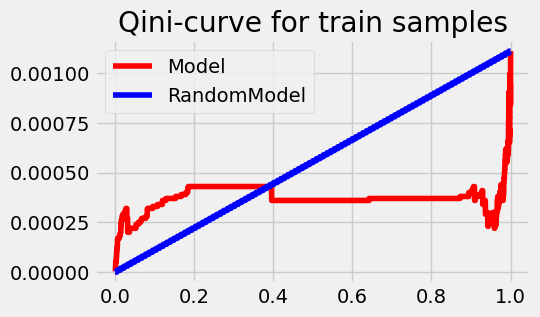

0.13589510182445066
Qini score: -18.028


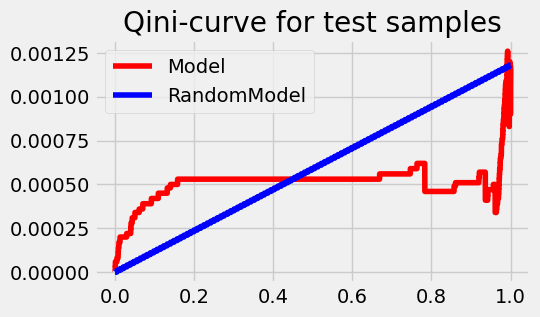

0.09947509936631535
Qini score: -3.383


In [26]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=7),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=df_train1[feature_cols],
    treatment=df_train1[treatment_col],
    y=df_train1[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_train1[feature_cols].values.copy()))
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_test1[feature_cols].values.copy()))
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

### R-learner

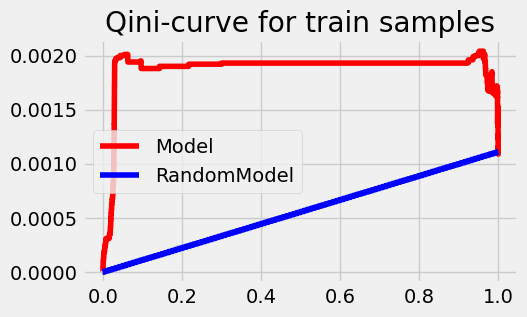

-0.18245096620619733
Qini score: 129.515


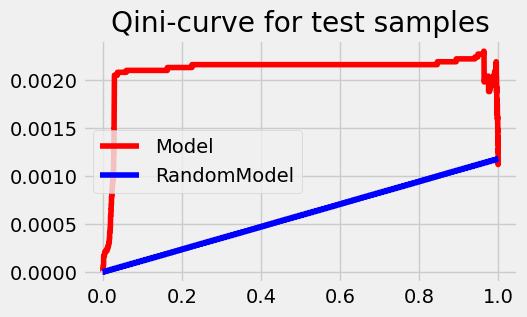

-0.158378946735954
Qini score: 63.292


In [27]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=7),
    effect_learner=LinearRegression(),
    random_state=7
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(
    X=df_train1[feature_cols],
    treatment=df_train1[treatment_col],
    y=df_train1[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_train1[feature_cols].values.copy()))
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_test1[feature_cols].values.copy()))
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

### Uplift-tree

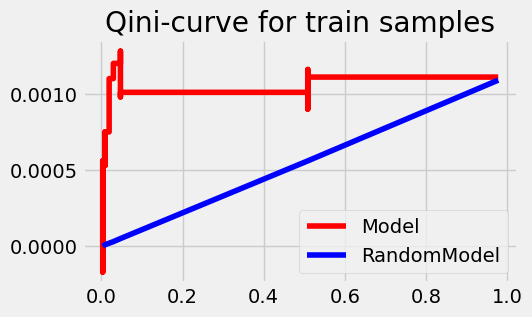

-0.15869672336220067
Qini score: 48.331


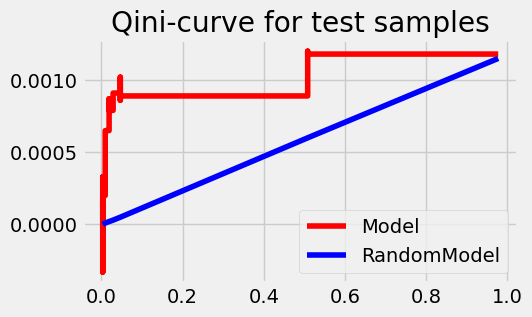

-0.1356933025778464
Qini score: 18.392


In [28]:
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=7
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    df_train1[feature_cols].values,
    treatment=df_train1[treatment_col].apply(str).values,
    y=df_train1[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_train1[feature_cols].values.copy()))[:, 1]
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_test1[feature_cols].values.copy()))[:, 1]
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

### UpliftRandomForest

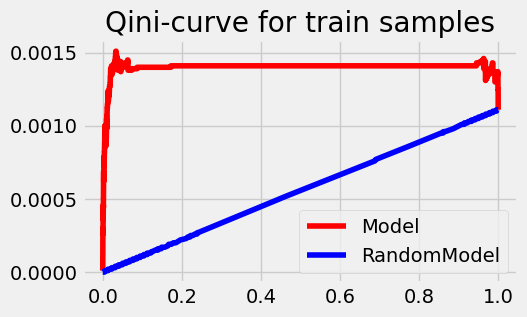

-0.1103843055555648
Qini score: 82.415


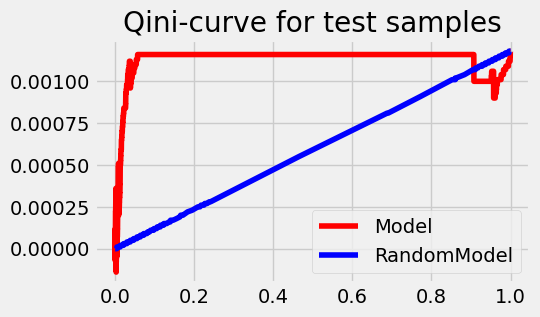

-0.1939114258314712
Qini score: 22.444


In [30]:
# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=7
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    df_train1[feature_cols].values,
    treatment=df_train1[treatment_col].apply(str).values,
    y=df_train1[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_train1[feature_cols].values.copy()))
df_train1['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_test1[feature_cols].values.copy()))
df_test1['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train1, title='train')
qini_df(df_test1, title='test')

Судя по нашеё метрике лучшие результаты показала модель R-learner. На второй вопрос даже не знаю как ответить потому что графики получились странные - где-то уходят в глубокий минус, а в других наоборот слишком хороши.